# Dataset and Other Sources

For this exercise, I am using the *Heart Disease* dataset found here: [uci](http://archive.ics.uci.edu/dataset/45/heart+disease)

I'm focused on one particular subset of this dataset, refered to as the *Cleaveland Database* that was already somewhat processed, narrowing the original 76 features down to just 14.

There's plenty of posted examples and discussion of this dataset, but I'm not looking at any of it. So, pretty much everything that follows is my own. I'll look over some of that stuff later, to get a sense for how well I did.

# Objective

- To demonstrate basic data exploration and cleaning techniques
- To use machine learning techniques to make predictions for a binary classification target
  - For this exercise, I ended up chosing to buld a neural newtork and logistic regression
  
# Outline
The basic steps I perform in this notebook provide a solid outline of how one might build any basic machine learning model.
1. Setup: Import packages and load the raw data
2. Understand and clean up the data
    - Make sure feature lables are meaningful
    - Choose target and variable features
    - Identify and handle missing data
    - Determine which variables are continuous (or numerical) and which are categorical
    - Determine how to handle categorical features
    - Observe the distributions of the numerical features, and their relationship to the target
    - Look for correlations between variable features
    - Decide if/how to rescale the numerical featues (normalizing vs standardizing)
3. Prepare the data for training the model
4. Choose an appropriate model
5. Train the model
6. Validate the model

I didn't do much feature engineering here, for the sake of simplicity. More work here could improve the results. 

# Set-up

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # or any {'0', '1', '2', '3'}
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [11]:
# Loading the dataset into a dataframe
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
                 header=None, 
                 na_values=['?','NA', 'NaN'])

# Understanding and Cleaning the Data

## Cleaning up Labels

The raw data doesn't have very  nice column names. Looking at the data source, we can relable our columns so that they are more descriptive:

1. age - age in years
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target - the predicted attribute - presense of of heart disease (angiographic disease status) (Value 0 = no heart disease present; Value > 0 = some presense of heart disearse)

In [12]:
# Relabeling labeling columns
new_labels = {0:'age',
              1:'sex',
              2:'cp',
              3:'trestbps',
              4:'chol',
              5:'fbs',
              6:'restecg',
              7:'thalach',
              8:'exang',
              9:'oldpeak',
              10:'slope',
              11:'ca',
              12:'thal',
              13:'target'}
df.rename(columns=new_labels, inplace=True)

## Getting the Data Ready for Training a Model

Only 6 rows out of 302 are missing any values. I'll just drop those.

### Identifying and preparing the target
The target column is provided with a range of values. We'll re-encode everything that isn't a `0` to `1`, so we can use binary classification techniques.

### Dealing with categorical features
We can leave binary values as they are, but we'll use one-hot encoding to create binary dummy variables for the remaining categorical features: `cp`, `fbs`, `restecg`, `slope`, and `thal`. I'll also encode `ca` like this, as that seems appropriate enough (given that my knowldge of "floroscopy" is entirely reliant on [wikipedia](https://en.wikipedia.org/wiki/Fluoroscopy)).

### Numerical features

The remaining features, `age`, `trestbps`, `chol`, `fbs`, `thalach`, and `oldpeak` are all numerical. Once the other variables are sorted, I'll do some further work with the numerical feartures to decide thenext steps.

In [13]:
# Show how many NaN values appear in each column
#display(df.isna().sum())
# Display all rows that contain NaN values
#display(df[df.isna().any(axis=1)])
# Drop rows with missing values
df.dropna()

# Keeping track of the target column
y_columns = 'target'

# Encoding the target variable as binary
df['target'] = df['target'].map(lambda x: 0 if x==0 else 1)

# One-hot encoding the categorical variables
categorical_features = ['cp', 'fbs', 'restecg', 'slope', 'thal', 'ca']
for feature in categorical_features:
    dummies = pd.get_dummies(df[feature], drop_first=True, prefix=feature)
    df = pd.concat([df,dummies],axis=1)
    df.drop(feature, axis=1, inplace=True)

Now, to get an idea of what to do with the numerical values I'll do the following for each:
1. Look at some descriptive statistics
2. Visialize the distribution
3. Visualize the relationship with the target
4. Calculate a corelation matrix to look for relationships between features

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604
std,9.038662,17.599748,51.776918,22.875003,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


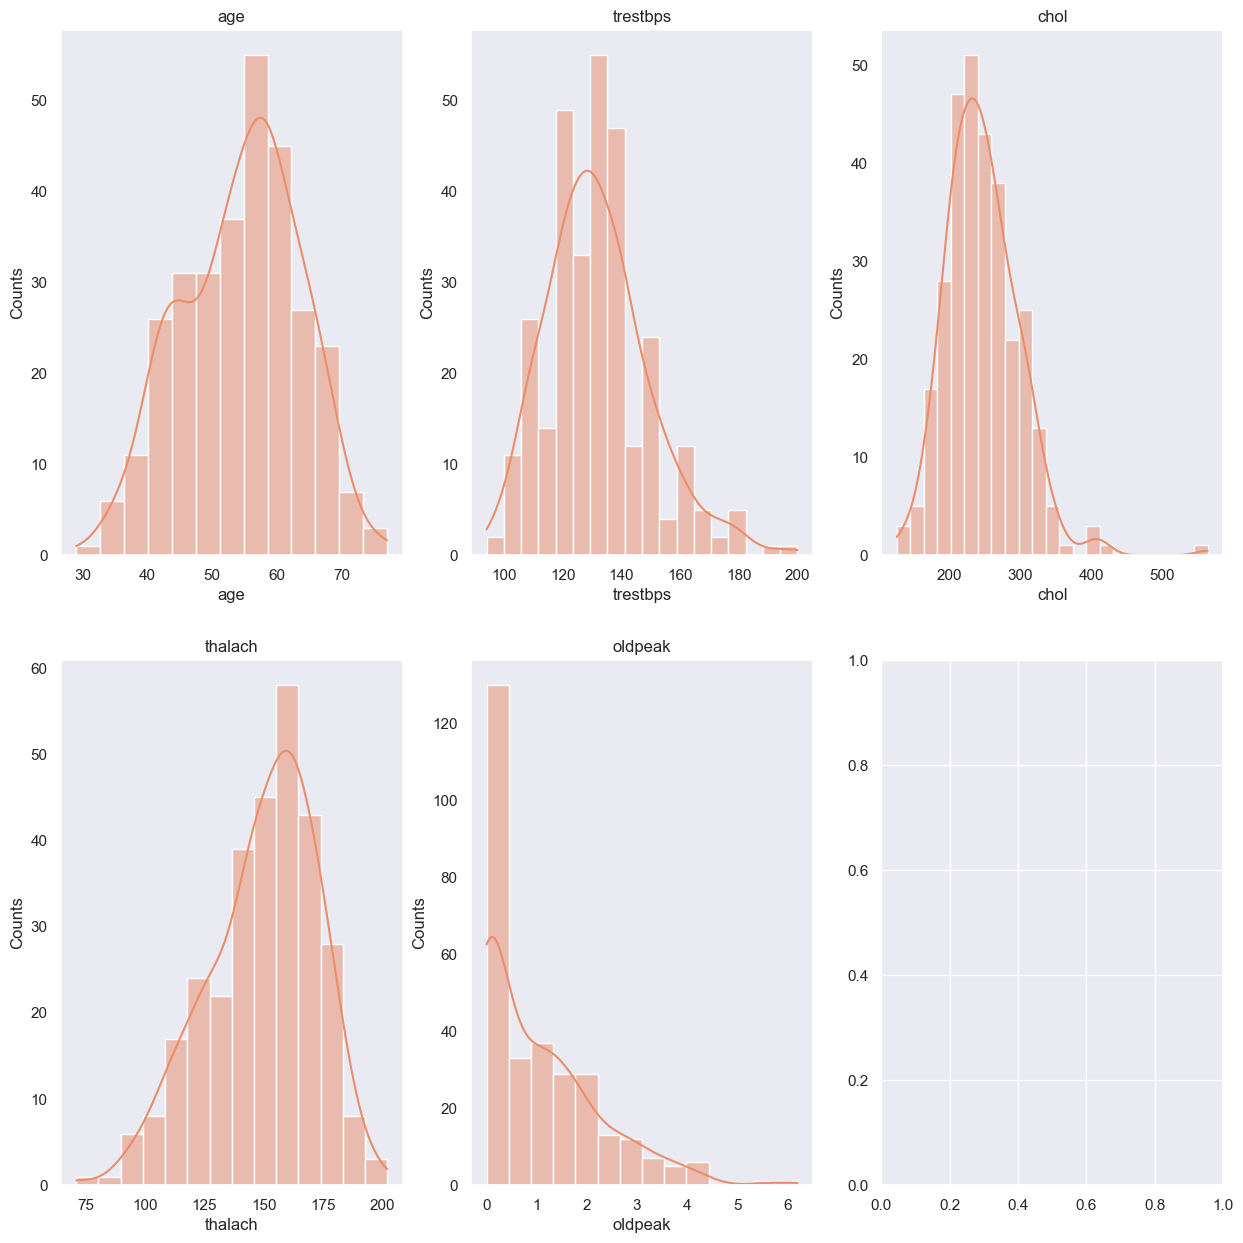

<Figure size 640x480 with 0 Axes>

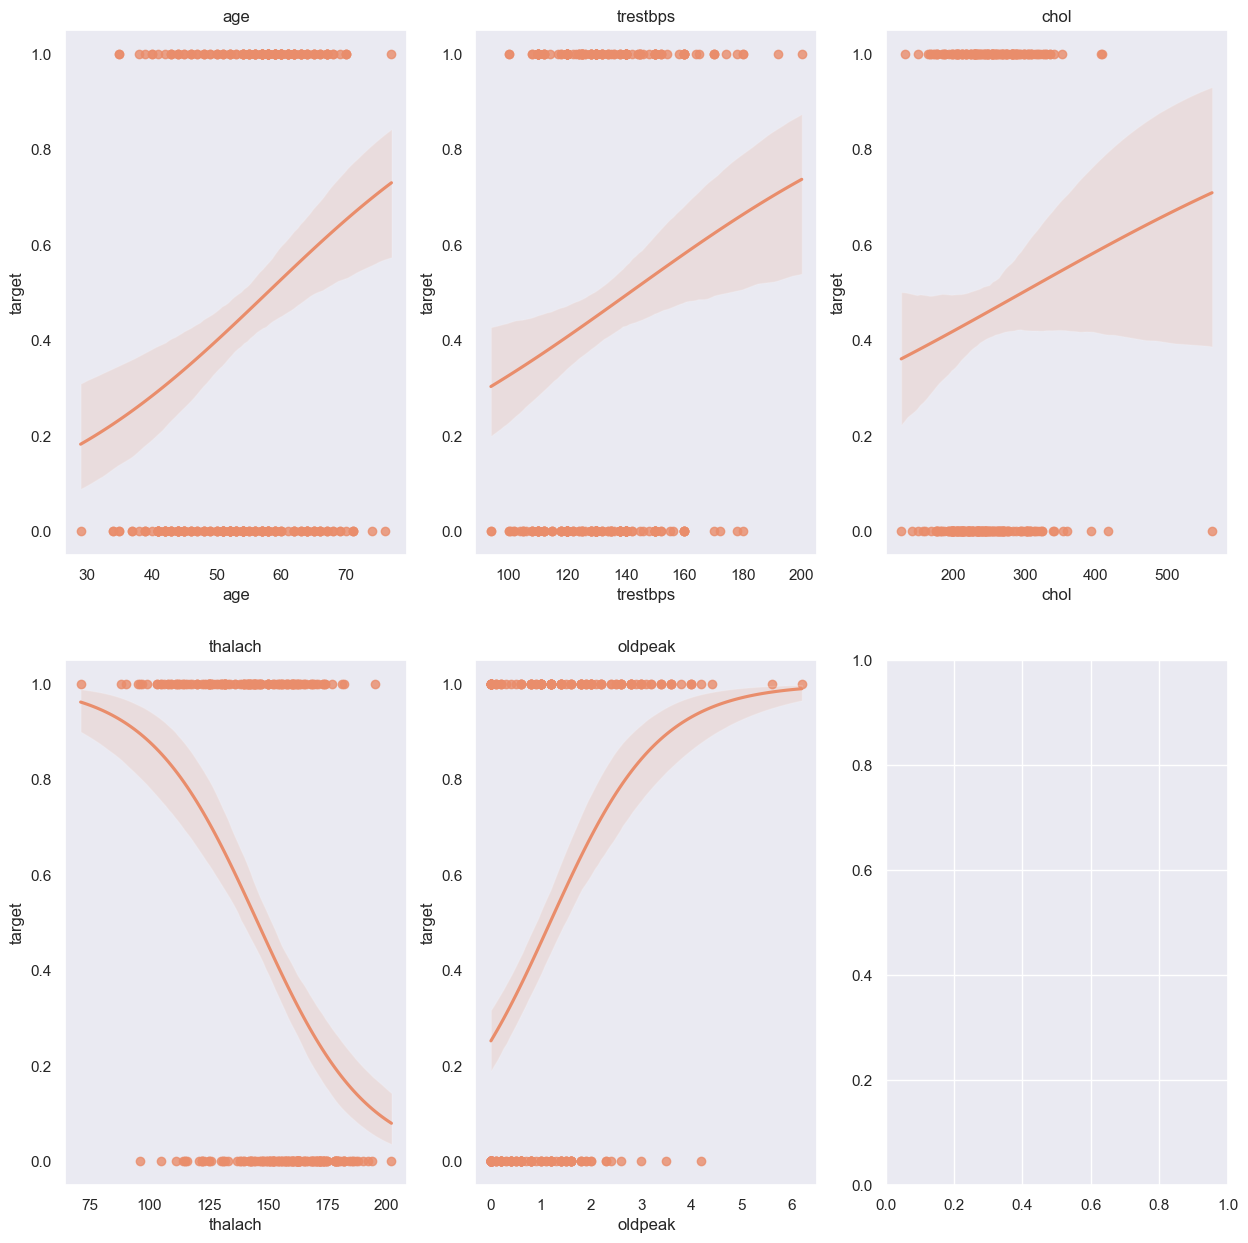

<Figure size 640x480 with 0 Axes>

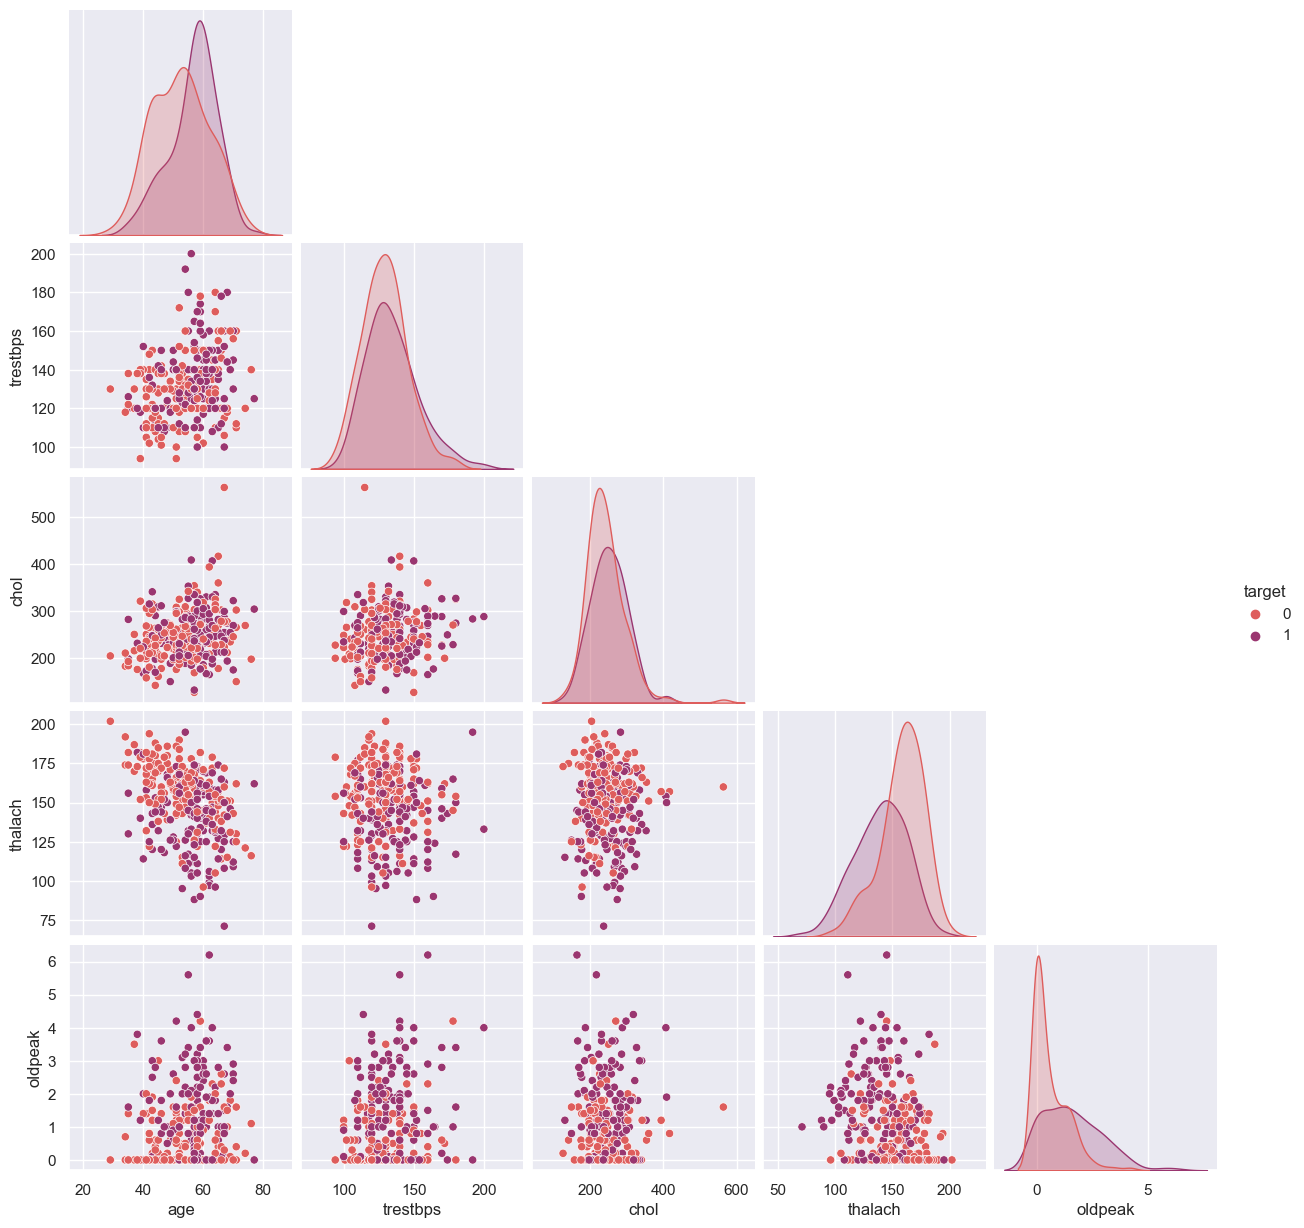

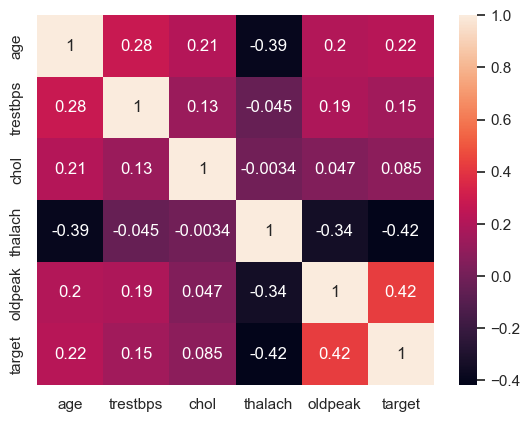

<Figure size 640x480 with 0 Axes>

In [14]:
# Observing properties of the numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
display(df[numerical_features].describe())

# Plotting some histograms
# Inspiration: https://dsaber.com/2014/05/24/matplotlib-scipy-numpy-and-pandas-coming-together-in-perfect-harmony/
#sb_dark = sns.dark_palette('skyblue', 8, reverse=True)
#seaborn.set(palette=sb_dark)
sns.set(palette='flare')

num_rows, num_columns = 2, 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15,15))
feature_axes = [ax for ax_row in axes for ax in ax_row]

for i, feature in enumerate(numerical_features):
    current_ax = feature_axes[i]
    current_feature_data = df[feature] # Store relevant column in current_month_data
    sns.histplot(current_feature_data, ax=current_ax, kde=True) # Ask Axes object to plot a histogram
    current_ax.set_title(feature) # Give our Axes a unique title
    current_ax.set_ylabel('Counts')
    current_ax.grid(False) # Turn off gridlines -- they're ugly

plt.show()
plt.clf()

# Scatterplots with logistic regression curves
num_rows, num_columns = 2, 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15,15))
feature_axes = [ax for ax_row in axes for ax in ax_row]

for i, feature in enumerate(numerical_features):
    current_ax = feature_axes[i]
    current_feature_data = df[feature] # Store relevant column in current_month_data
    sns.regplot(data=df, x=feature, y='target', ax=current_ax, logistic=True)
    current_ax.set_title(feature) # Give our Axes a unique title
    current_ax.set_ylabel('target')
    current_ax.grid(False) # Turn off gridlines -- they're ugly
    
plt.show()
plt.clf()

# Pairplots colored by the target
sns.pairplot(df[numerical_features+['target']], hue='target', corner=True, palette='flare')

plt.show()
plt.clf()

# Heatmap with correlation data
sns.heatmap(df[numerical_features+['target']].corr(), annot=True)
plt.show()
plt.clf()

## Rescaling

I'm going to standardize the numerical values because:
1. I forsee using a model that relies on logistic regression, and optimizing the parameters will be more efficient if the ranges for each variable are more similar
2. All of the numerical features appear to have roughly Gaussian distribution, so this seems more appropriate than normalization

In [15]:
for feature in numerical_features:
    df[feature] = stats.zscore(df[feature])

## Preparing the data for training a model

I plan to use tools from `tensorflow` and `keras` or classification, so I need my data to be stored in `numpy` arrays.

I'm also going to quarantine a portion of the dataset for validation after taining the model.

In [16]:
# Converting variable features
x_columns = df.columns.drop(y_columns)
x = df[x_columns].values

# Converting target features
y = df[y_columns].values

# Quarnatinining a holdout set for later validation
x_main, x_holdout, y_main, y_holdout = train_test_split(
    x, y, 
    test_size=0.1, 
    random_state=45)

# Building and Testing the Model

I'm going to build a basic logistic regression model using stratified k-fold validation to reduce the chance of overfitting. (If this isn't enough, I can always add some regularization.)

I'm using `roc_auc_score` to evaluate the perfomance of the model. This compute the area under the receiver operating characteristic curve, and is a standard measure of accurace for classification models.

In [23]:
# Cross-validate
# Using for StratifiedKFold classification
kf = StratifiedKFold(5, shuffle=True, random_state=42) 

# Keeping track of out of sample data for scoring
oos_y = []
oos_pred = []

# Counting the folds
fold = 0
for train, test in kf.split(x_main,y_main):
    # Itterate the fold count
    fold+=1
    print(f"Fold #{fold}")
    
    # Define the training and test sets for the model
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    # Defining the model
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid')) # sigmoid for classification
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam',
                  metrics =['accuracy'])
    
    # Setting up early stopping
    monitor = EarlyStopping(monitor='val_loss', 
                            min_delta=1e-3, 
                            patience=5, 
                            verbose=0,
                            mode='auto', 
                            restore_best_weights=True)
    
    # Fitting the model to the data
    model.fit(x_train,
              y_train,
              validation_data=(x_test,y_test),
              callbacks=[monitor],
              verbose=0,
              epochs=500)
    
    # Find the predicted outputs for this itteretion
    y_pred = model.predict(x_test)
    
    # Add test outputs for this itteration to the oss list
    oos_y.append(y_test)
    # Just round to get binary prediction
    y_pred = np.round(y_pred)
    # Add predictions for this itteration to the oss list
    oos_pred.append(y_pred)  

    # Measure this fold's accuracy
    score = roc_auc_score(y_test, y_pred)
    print(f"Fold score (accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = roc_auc_score(oos_y, oos_pred)
print(f"\n\nFinal score (accuracy): {score}\n\n")    
    
# Compare perfomance of the last model on the holdout set
pred_holdout = model.predict(x_holdout)
score = roc_auc_score(y_holdout, pred_holdout)
print(f"Holdout score (accuracy): {score}")

Fold #1
2/2 [==============================] - 0s 4ms/step
Fold score (accuracy): 0.836870026525199
Fold #2
2/2 [==============================] - 0s 4ms/step
Fold score (accuracy): 0.83
Fold #3
2/2 [==============================] - 0s 4ms/step
Fold score (accuracy): 0.7365517241379311
Fold #4
2/2 [==============================] - 0s 5ms/step
Fold score (accuracy): 0.8682758620689656
Fold #5
2/2 [==============================] - 0s 4ms/step
Fold score (accuracy): 0.8827586206896553


Final score (accuracy): 0.8305066318764949


1/1 [==============================] - 0s 12ms/step
Holdout score (accuracy): 0.9188034188034189


# Results

It looks like we can build an okay (~80% accuracy) model using this approach. The perfomance on the holdout set scored even higher than on the test sets, which mean we probably aren't introducing too much overfitting.

If this isn't accurate enough, we can start making some modifactions. Maybe try some feature engineering, or changing the way we scaled the features. We could also experiment with a support vercor algorithm, or a tree-based algorithm, or something else, to see if any improvement could be gained there.